# SGDClassifier(LinearSVC) 
### Linear SVC  implementation with SGD Classifier to speed up training 
#### Import Requirements 

In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 
#from pandas.tools.plotting import table

#memory management
import gc

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

#Logistic regression
from sklearn.linear_model import SGDClassifier


#to measure ROC AUC performance
from sklearn.metrics import roc_auc_score, roc_curve, auc

from sklearn.model_selection import KFold

from scipy import interp
import matplotlib.pyplot as plt

### Set folder paths for getting input and saving outputs

In [2]:
#Set input data folder 
dataFolder = os.getcwd()+os.sep+os.pardir+os.sep+os.pardir+ os.sep + 'NoteBookOutputs'
if(not os.path.exists(dataFolder)):
    print("Input Data folder not found. Please specify data folder path as dataFolder variable to proceed")
    raise NotADirectoryError
    
#Create output folder is it does not exist
outputFolder = os.getcwd()+os.sep+os.pardir+os.sep+os.pardir+ os.sep + 'NoteBookOutputs'

if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)
    print('Output Folder created')

### Read input

In [3]:
# Read Training data
input_df = pd.read_csv(dataFolder + '\\DataSetVersion2_a.csv')
print(input_df.shape)
input_df.head()

(244280, 62)


,Unnamed: 0,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,100008,0,0,99000.0,490495.5,27517.5,454500.0,0.035792,-16941,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
3,6,100009,0,1,171000.0,1560726.0,41301.0,1395000.0,0.035792,-13778,...,0,0,0,0,0.0,0.0,0.0,1.0,1.0,2.0
4,7,100010,0,0,360000.0,1530000.0,42075.0,1530000.0,0.003122,-18850,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done  52 out of  60 | elapsed: 13.7min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 15.3min finished


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.8s finished


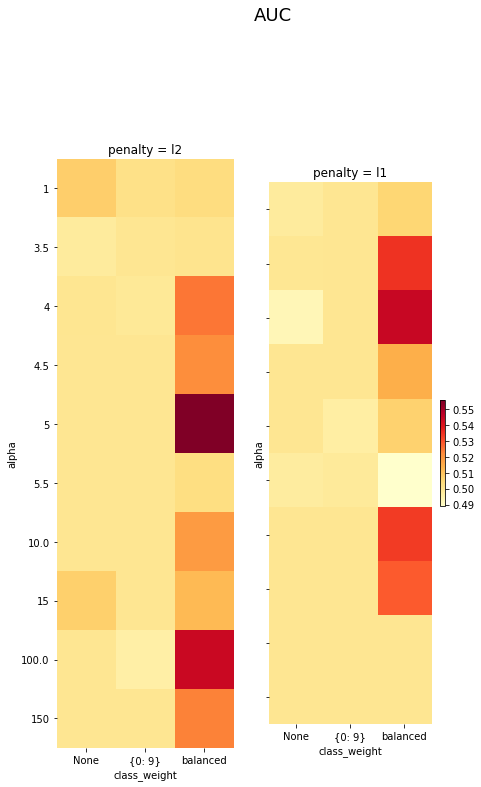

SGDClassifier(alpha=5, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=-1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False) 0.555677860419199


In [29]:
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
import parfit.parfit as pf
from sklearn.model_selection import train_test_split

grid = {
    'alpha': [1,3.5, 4, 4.5, 5, 5.5, 1e1, 15, 1e2, 150], # learning rate
    'max_iter': [1000], # number of epochs
    'loss': ['hinge'], 
    'penalty': ['l2', 'l1'],
    'class_weight' : [None, {0:9}, 'balanced'],
    'n_jobs': [-1]
}
paramGrid = ParameterGrid(grid)

X_train, X_test, y_train, y_test = train_test_split(input_df, labels, test_size=0.33, random_state=42)

bestModel, bestScore, allModels, allScores = pf.bestFit(SGDClassifier(), paramGrid,
           X_train, y_train, X_test, y_test, 
           metric = roc_auc_score, greater_is_better=True,
           predict_proba=False, scoreLabel = "AUC")

print(bestModel, bestScore)

In [30]:
def svclassifier(df, labels):
    # #############################################################################
    # Classification and ROC analysis

    # Run classifier with cross-validation and plot ROC curves
    cv = KFold(n_splits=10)
    #linearSVC = SGDClassifier(alpha=5.5, average=False, class_weight=None, epsilon=0.1,
    #   eta0=0.0, fit_intercept=True, l1_ratio=0.15,
    #   learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
    #   n_jobs=-1, penalty='l2', power_t=0.5, random_state=None,
    #   shuffle=True, tol=None, verbose=0, warm_start=False)
    
    linearSVC = SGDClassifier(alpha=.55, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=-1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)


    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    for trainSet, testSet in cv.split(df, labels):
        model = linearSVC.fit(df.iloc[trainSet], labels.iloc[trainSet])
        probas_ = np.array(linearSVC.decision_function(df.iloc[testSet]))

        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(labels[testSet], probas_)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3)#,
        #label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
        
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [14]:
labels = input_df.pop('TARGET')
input_df = input_df.drop(columns='SK_ID_CURR')

KeyError: 'TARGET'

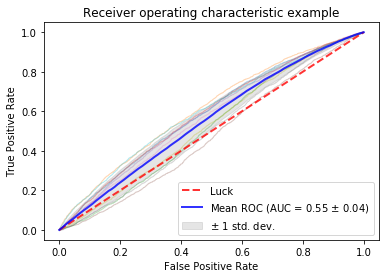

In [31]:
svclassifier(input_df, labels)